In [10]:
import torch
from finetune import Resnet18Finetuner, Resnet18FintunerForCaseD
from dataloader import load_augmented_data
import matplotlib.pyplot as plt
from trainer import Trainer
from torch import optim, nn

In [11]:
finetuner_base = Resnet18Finetuner(pretrained=True, feature_extract=True)
finetuner_base.add_final_layers()

finetuner_A = Resnet18Finetuner(pretrained=True, feature_extract=True)
finetuner_A.add_final_layers()

finetuner_B = Resnet18Finetuner(pretrained=True, feature_extract=False)  # make all conv blocks trainable
finetuner_B.add_final_layers()

finetuner_C = Resnet18FintunerForCaseD(pretrained=True, feature_extract=True)
finetuner_C.add_final_layers()

In [12]:
finetuner_base.model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [13]:
data_dir = "../face_dataset"

## Set hyperparameters and share with all cases

In [22]:
input_size = 64
batch_size = 256
num_epochs = 50
lr = 0.002
num_workers = 4  # how many subprocesses to use for data loading

In [23]:
dataloaders_dict = load_augmented_data(input_size, batch_size, data_dir, num_workers)
dataloaders_dict

Initializing Datasets and Dataloaders...


{'train': <torch.utils.data.dataloader.DataLoader at 0x1951d1c1b20>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1951d1c1c40>}

In [24]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Case A: Re-train the softmax layer (Baseline model)

When finetuning all resnet layers, feature_extract = False, the model is finetuned and all model parameters are updated.  
If feature_extract = True, only the last layer parameters are updated, the others remain fixed.

In [25]:
finetuner_base.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# Train and evaluate
trainer_base = Trainer(finetuner_base)
fine_tuned_model_base, hist_base = trainer_base.fit(
    dataloaders=dataloaders_dict,
    num_epochs=num_epochs,
    lr=lr,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    device=device
)

train_loss_hist_base, train_acc_hist_base, test_loss_hist_base, test_acc_hist_base = hist_base

Params to learn:
	 fc.weight
	 fc.bias
	 batch_norm.weight
	 batch_norm.bias
Epoch 0/49
----------
train Loss: 4.0530 Acc: 0.1150
test Loss: 3.8707 Acc: 0.1570

Epoch 1/49
----------
train Loss: 3.9766 Acc: 0.1262
test Loss: 3.8448 Acc: 0.1350

Epoch 2/49
----------
train Loss: 3.9472 Acc: 0.1250
test Loss: 3.8411 Acc: 0.1380

Epoch 3/49
----------
train Loss: 3.9122 Acc: 0.1393
test Loss: 3.7976 Acc: 0.1520

Epoch 4/49
----------
train Loss: 3.9118 Acc: 0.1438
test Loss: 3.7572 Acc: 0.1560

Epoch 5/49
----------
train Loss: 3.8833 Acc: 0.1438
test Loss: 3.7336 Acc: 0.1460

Epoch 6/49
----------
train Loss: 3.8658 Acc: 0.1523
test Loss: 3.7240 Acc: 0.1660

Epoch 7/49
----------
train Loss: 3.8507 Acc: 0.1483
test Loss: 3.7043 Acc: 0.1890

Epoch 8/49
----------
train Loss: 3.8342 Acc: 0.1570
test Loss: 3.6849 Acc: 0.1910

Epoch 9/49
----------
train Loss: 3.8368 Acc: 0.1550
test Loss: 3.6772 Acc: 0.1920

Epoch 10/49
----------
train Loss: 3.8430 Acc: 0.1500
test Loss: 3.7652 Acc: 0.1480

## Case B: Fine tune Conv5_x and freeze the rest of Conv blocks

In [27]:
# Unfreeze layer4 in Resnet18
finetuner_A.unfreeze_layer("layer4")

In [28]:
# Train and evaluate
trainer_A = Trainer(finetuner_A)
fine_tuned_model_A, hist_A = trainer_A.fit(
    dataloaders=dataloaders_dict,
    num_epochs=num_epochs,
    lr=lr,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    device=device
)

train_loss_hist_A, train_acc_hist_A, test_loss_hist_A, test_acc_hist_A = hist_A

Params to learn:
	 fc.weight
	 fc.bias
	 batch_norm.weight
	 batch_norm.bias
Epoch 0/49
----------
train Loss: 4.0579 Acc: 0.1105
test Loss: 3.9105 Acc: 0.1410

Epoch 1/49
----------
train Loss: 4.0118 Acc: 0.1205
test Loss: 3.8579 Acc: 0.1430

Epoch 2/49
----------
train Loss: 3.9594 Acc: 0.1295
test Loss: 3.8005 Acc: 0.1780

Epoch 3/49
----------
train Loss: 3.9371 Acc: 0.1345
test Loss: 3.8029 Acc: 0.1570

Epoch 4/49
----------
train Loss: 3.9495 Acc: 0.1305
test Loss: 3.7390 Acc: 0.1680

Epoch 5/49
----------
train Loss: 3.8818 Acc: 0.1380
test Loss: 3.7373 Acc: 0.1730

Epoch 6/49
----------
train Loss: 3.8849 Acc: 0.1430
test Loss: 3.7100 Acc: 0.1850

Epoch 7/49
----------
train Loss: 3.8656 Acc: 0.1463
test Loss: 3.6824 Acc: 0.1760

Epoch 8/49
----------
train Loss: 3.8484 Acc: 0.1525
test Loss: 3.6800 Acc: 0.1870

Epoch 9/49
----------
train Loss: 3.8520 Acc: 0.1458
test Loss: 3.6588 Acc: 0.1840

Epoch 10/49
----------
train Loss: 3.8173 Acc: 0.1533
test Loss: 3.7326 Acc: 0.1460

## Case C: Fine tune ALL convolution layers.

In [29]:
# Train and evaluate
trainer_B = Trainer(finetuner_B)
fine_tuned_model_B, hist_B = trainer_B.fit(
    dataloaders=dataloaders_dict,
    num_epochs=num_epochs,
    lr=lr,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    device=device
)

train_loss_hist_B, train_acc_hist_B, test_loss_hist_B, test_acc_hist_B = hist_B

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

## Case D: Freeze all the convolution blocks, introduce two FC layers prior to the softmax layer

In [30]:
trainer_C = Trainer(finetuner_C)
fine_tuned_model_C, hist_C = trainer_C.fit(
    dataloaders=dataloaders_dict,
    num_epochs=num_epochs,
    lr=lr,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    device=device
)

train_loss_hist_C, train_acc_hist_C, test_loss_hist_C, test_acc_hist_C = hist_C

Params to learn:
	 fc.weight
	 fc.bias
	 batch_norm.weight
	 batch_norm.bias
	 fc_2.weight
	 fc_2.bias
	 batch_norm_2.weight
	 batch_norm_2.bias
Epoch 0/49
----------
train Loss: 4.8325 Acc: 0.0085
test Loss: 4.7036 Acc: 0.0110

Epoch 1/49
----------
train Loss: 4.6518 Acc: 0.0213
test Loss: 4.5648 Acc: 0.0240

Epoch 2/49
----------
train Loss: 4.5471 Acc: 0.0285
test Loss: 4.4695 Acc: 0.0420

Epoch 3/49
----------
train Loss: 4.4893 Acc: 0.0415
test Loss: 4.4181 Acc: 0.0530

Epoch 4/49
----------
train Loss: 4.3991 Acc: 0.0518
test Loss: 4.3748 Acc: 0.0560

Epoch 5/49
----------
train Loss: 4.3629 Acc: 0.0558
test Loss: 4.2671 Acc: 0.0690

Epoch 6/49
----------
train Loss: 4.2993 Acc: 0.0690
test Loss: 4.2187 Acc: 0.0840

Epoch 7/49
----------
train Loss: 4.2722 Acc: 0.0750
test Loss: 4.1752 Acc: 0.0880

Epoch 8/49
----------
train Loss: 4.2246 Acc: 0.0925
test Loss: 4.1178 Acc: 0.0860

Epoch 9/49
----------
train Loss: 4.2047 Acc: 0.0855
test Loss: 4.0830 Acc: 0.1030

Epoch 10/49
---

## Results

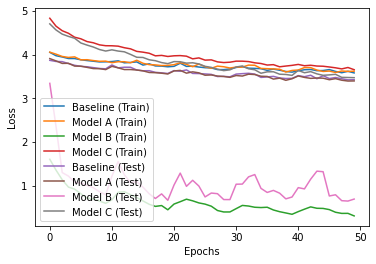

In [31]:
plt.plot(train_loss_hist_base, label='Baseline (Train)')
plt.plot(train_loss_hist_A, label='Model A (Train)')
plt.plot(train_loss_hist_B, label='Model B (Train)')
plt.plot(train_loss_hist_C, label='Model C (Train)')
plt.plot(test_loss_hist_base, label='Baseline (Test)')
plt.plot(test_loss_hist_A, label='Model A (Test)')
plt.plot(test_loss_hist_B, label='Model B (Test)')
plt.plot(test_loss_hist_C, label='Model C (Test)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

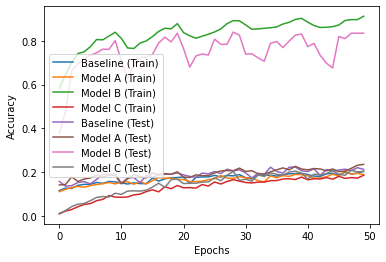

In [32]:
plt.plot(train_acc_hist_base, label='Baseline (Train)')
plt.plot(train_acc_hist_A, label='Model A (Train)')
plt.plot(train_acc_hist_B, label='Model B (Train)')
plt.plot(train_acc_hist_C, label='Model C (Train)')
plt.plot(test_acc_hist_base, label='Baseline (Test)')
plt.plot(test_acc_hist_A, label='Model A (Test)')
plt.plot(test_acc_hist_B, label='Model B (Test)')
plt.plot(test_acc_hist_C, label='Model C (Test)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()